In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import pandas as pd
from datetime import datetime
import time

In [ ]:
# for reproducibility
np.random.seed(42)

print("Loading Fashion-MNIST dataset: ")
fashion_mnist = fetch_openml('Fashion-MNIST', version=1, parser='auto')

X = fashion_mnist.data.values
y = fashion_mnist.target.values

# normalize pixel values
X = X / 255.0

print(f"Dataset shape: {X.shape}")
print(f"Dataset size: {X.shape[0]} images")



Loading Fashion-MNIST dataset: 
Dataset shape: (70000, 784)
Dataset size: 70000 images


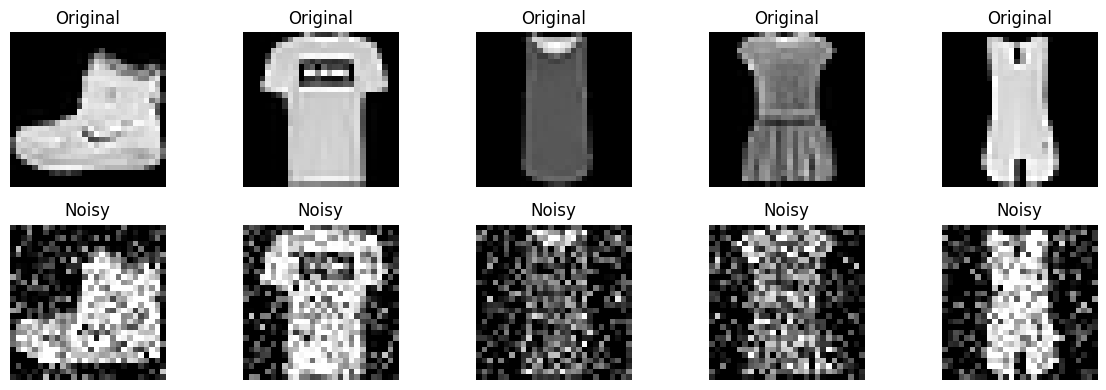

In [ ]:
# function to add random gaussian noise to each pixel
def add_noise(images, noise_factor=0.3):
    noisy_images = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    return np.clip(noisy_images, 0., 1.)

X_noisy = add_noise(X, noise_factor=0.3)

# Visualization of images
fig, axes = plt.subplots(2, 5, figsize=(12, 4))

for i in range(5):
    axes[0, i].imshow(X[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title('Original')
    axes[1, i].imshow(X_noisy[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title('Noisy')

plt.tight_layout()
plt.show()

In [ ]:
# splitting the noisy and clean data into training and testing sets
X_train_noisy, X_test_noisy, X_train_clean, X_test_clean = train_test_split(X_noisy, X, test_size=0.2, random_state=42)
print(f"Training set: {X_train_noisy.shape[0]} samples")
print(f"Test set: {X_test_noisy.shape[0]} samples")

Training set: 56000 samples
Test set: 14000 samples


In [ ]:
# sigmoid activation function
def sigmoid(x):
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

# derivative of sigmoid function
def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

# relu activation function
def relu(x):
    return np.maximum(0, x)

# derivative of relu function
def relu_derivative(x):
    return (x > 0).astype(float)

In [ ]:
class Autoencoder:
    # initialize hyperparamters and weights for autoencoder
    def __init__(self, input_dim, encoding_dims, learning_rate = 0.01, regularization = 0.0):
        self.input_dim = input_dim
        self.encoding_dims = encoding_dims
        self.learning_rate = learning_rate
        self.regularization = regularization
        self.initialize_weights()
        self.train_losses = []
        self.test_losses = []

    # initializing weights using He initialization
    def initialize_weights(self):
        self.W1 = np.random.randn(self.input_dim, self.encoding_dims[0]) * np.sqrt(2.0 / self.input_dim)
        self.b1 = np.zeros((1, self.encoding_dims[0]))
        self.W2 = np.random.randn(self.encoding_dims[0], self.encoding_dims[1]) * np.sqrt(2.0 / self.encoding_dims[0])
        self.b2 = np.zeros((1, self.encoding_dims[1]))
        self.W3 = np.random.randn(self.encoding_dims[1], self.encoding_dims[2]) * np.sqrt(2.0 / self.encoding_dims[1])
        self.b3 = np.zeros((1, self.encoding_dims[2]))
        self.W4 = np.random.randn(self.encoding_dims[2], self.input_dim) * np.sqrt(2.0 / self.encoding_dims[2])
        self.b4 = np.zeros((1, self.input_dim))

    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = relu(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = relu(self.z2)
        self.z3 = np.dot(self.a2, self.W3) + self.b3
        self.a3 = relu(self.z3)
        self.z4 = np.dot(self.a3, self.W4) + self.b4
        self.a4 = sigmoid(self.z4)
        return self.a4

    def compute_loss(self, X, X_target):
        m = X.shape[0]
        predictions = self.forward(X)
        mse_loss = np.mean((predictions - X_target) ** 2)
        reg_loss = (self.regularization / (2 * m)) * (
            np.sum(self.W1**2) + np.sum(self.W2**2) + np.sum(self.W3**2) + np.sum(self.W4**2)
        )
        return mse_loss + reg_loss, mse_loss

    def backward(self, X, X_target):
        m = X.shape[0]
        dz4 = (self.a4 - X_target) * sigmoid_derivative(self.z4)
        dW4 = (1/m) * np.dot(self.a3.T, dz4) + (self.regularization/m) * self.W4
        db4 = (1/m) * np.sum(dz4, axis=0, keepdims=True)
        da3 = np.dot(dz4, self.W4.T)
        dz3 = da3 * relu_derivative(self.z3)
        dW3 = (1/m) * np.dot(self.a2.T, dz3) + (self.regularization/m) * self.W3
        db3 = (1/m) * np.sum(dz3, axis=0, keepdims=True)
        da2 = np.dot(dz3, self.W3.T)
        dz2 = da2 * relu_derivative(self.z2)
        dW2 = (1/m) * np.dot(self.a1.T, dz2) + (self.regularization/m) * self.W2
        db2 = (1/m) * np.sum(dz2, axis=0, keepdims=True)
        da1 = np.dot(dz2, self.W2.T)
        dz1 = da1 * relu_derivative(self.z1)
        dW1 = (1/m) * np.dot(X.T, dz1) + (self.regularization/m) * self.W1
        db1 = (1/m) * np.sum(dz1, axis=0, keepdims=True)
        return dW1, db1, dW2, db2, dW3, db3, dW4, db4

    # updating weights and bias using gradient descent
    def update_weights(self, dW1, db1, dW2, db2, dW3, db3, dW4, db4):
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2
        self.W3 -= self.learning_rate * dW3
        self.b3 -= self.learning_rate * db3
        self.W4 -= self.learning_rate * dW4
        self.b4 -= self.learning_rate * db4

    # Training autoencoder using mini batch gradient descent.
    def train(self, X_train, X_train_target, X_test, X_test_target, epochs, batch_size = 32):
        n_samples = X_train.shape[0]
        n_batches = n_samples // batch_size
        for epoch in range(epochs):
            indices = np.random.permutation(n_samples)
            X_shuffled = X_train[indices]
            X_target_shuffled = X_train_target[indices]

            for batch in range(n_batches):
                start = batch * batch_size
                end = start + batch_size
                self.forward(X_shuffled[start:end])
                grads = self.backward(X_shuffled[start:end], X_target_shuffled[start:end])
                self.update_weights(*grads)
            _, train_mse = self.compute_loss(X_train, X_train_target)
            _, test_mse = self.compute_loss(X_test, X_test_target)

            self.train_losses.append(train_mse)
            self.test_losses.append(test_mse)
            if (epoch + 1) % 5 == 0:
                print(f"Epoch {epoch+1}/{epochs} - Train MSE: {train_mse:.6f}, Test MSE: {test_mse:.6f}")

    def predict(self, X):
        return self.forward(X)

In [ ]:
# Track all experiments
results = []
models = {}

In [ ]:
print("="*60)
print("EXPERIMENT 1: Baseline Model")
print("="*60)

model_1 = Autoencoder(input_dim= 784, encoding_dims=[128, 32, 128], learning_rate=0.01, regularization=0.0)

model_1.train(X_train_noisy, X_train_clean, X_test_noisy, X_test_clean, epochs=20, batch_size=32)

# Store results
results.append({
    'Experiment': 1,
    'Description': 'Baseline',
    'Architecture': '[784, 128, 32, 128, 784]',
    'Learning_Rate': 0.01,
    'Regularization': 0.0,
    'Train_MSE': model_1.train_losses[-1],
    'Test_MSE': model_1.test_losses[-1]
})
models[1] = model_1

print(f"\nFinal Test MSE: {model_1.test_losses[-1]:.6f}")

EXPERIMENT 1: Baseline Model
Epoch 5/20 - Train MSE: 0.022111, Test MSE: 0.022094
Epoch 10/20 - Train MSE: 0.020311, Test MSE: 0.020369
Epoch 15/20 - Train MSE: 0.018657, Test MSE: 0.018771
Epoch 20/20 - Train MSE: 0.018824, Test MSE: 0.018965

Final Test MSE: 0.018965


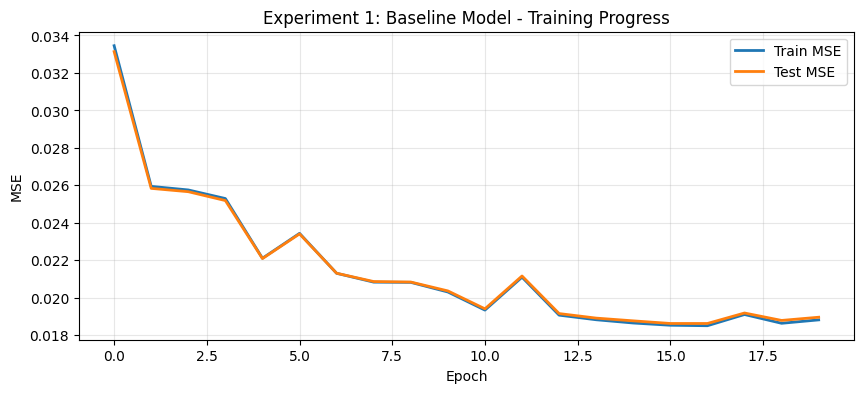

In [ ]:
# Visualize Experiment 1 training progress
plt.figure(figsize=(10, 4))
plt.plot(model_1.train_losses, label='Train MSE', linewidth=2)
plt.plot(model_1.test_losses, label='Test MSE', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Experiment 1: Baseline Model - Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
print("="*60)
print("EXPERIMENT 2: Smaller Latent Dimension")
print("="*60)

 # Latent = 16 instead of 32
model_2 = Autoencoder(input_dim=784, encoding_dims=[128, 16, 128], learning_rate=0.01, regularization=0.0)

model_2.train(X_train_noisy, X_train_clean, X_test_noisy, X_test_clean, epochs=20, batch_size=32)

results.append({
    'Experiment': 2,
    'Description': 'Smaller Latent (16)',
    'Architecture': '[784, 128, 16, 128, 784]',
    'Learning_Rate': 0.01,
    'Regularization': 0.0,
    'Train_MSE': model_2.train_losses[-1],
    'Test_MSE': model_2.test_losses[-1]
})
models[2] = model_2

print(f"\nFinal Test MSE: {model_2.test_losses[-1]:.6f}")

EXPERIMENT 2: Smaller Latent Dimension
Epoch 5/20 - Train MSE: 0.025235, Test MSE: 0.025162
Epoch 10/20 - Train MSE: 0.023386, Test MSE: 0.023415
Epoch 15/20 - Train MSE: 0.021611, Test MSE: 0.021697
Epoch 20/20 - Train MSE: 0.020283, Test MSE: 0.020426

Final Test MSE: 0.020426


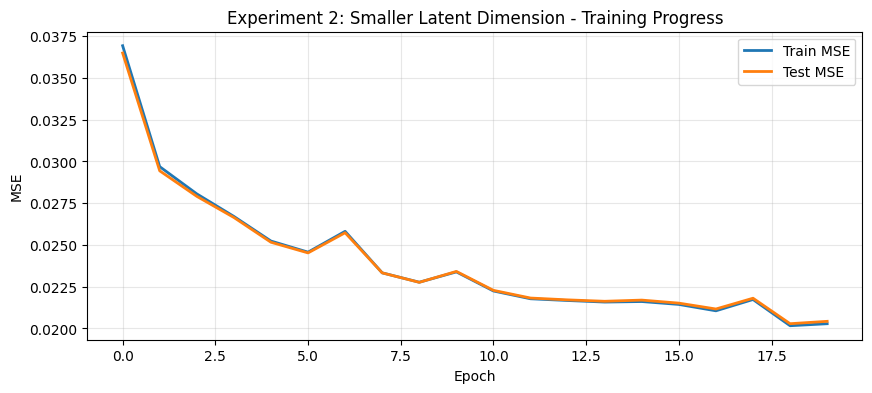

In [ ]:
# Visualize Experiment 2 training progress
plt.figure(figsize=(10, 4))
plt.plot(model_2.train_losses, label='Train MSE', linewidth=2)
plt.plot(model_2.test_losses, label='Test MSE', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Experiment 2: Smaller Latent Dimension - Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
print("="*60)
print("EXPERIMENT 3: With L2 Regularization")
print("="*60)

# Added regularization
model_3 = Autoencoder(input_dim=784, encoding_dims=[128, 32, 128], learning_rate=0.01, regularization=0.001)

model_3.train(X_train_noisy, X_train_clean, X_test_noisy, X_test_clean, epochs=20, batch_size=32)

results.append({
    'Experiment': 3,
    'Description': 'L2 Regularization',
    'Architecture': '[784, 128, 32, 128, 784]',
    'Learning_Rate': 0.01,
    'Regularization': 0.001,
    'Train_MSE': model_3.train_losses[-1],
    'Test_MSE': model_3.test_losses[-1]
})
models[3] = model_3

print(f"\nFinal Test MSE: {model_3.test_losses[-1]:.6f}")

EXPERIMENT 3: With L2 Regularization
Epoch 5/20 - Train MSE: 0.023755, Test MSE: 0.023670
Epoch 10/20 - Train MSE: 0.020186, Test MSE: 0.020222
Epoch 15/20 - Train MSE: 0.018116, Test MSE: 0.018235
Epoch 20/20 - Train MSE: 0.017947, Test MSE: 0.018094

Final Test MSE: 0.018094


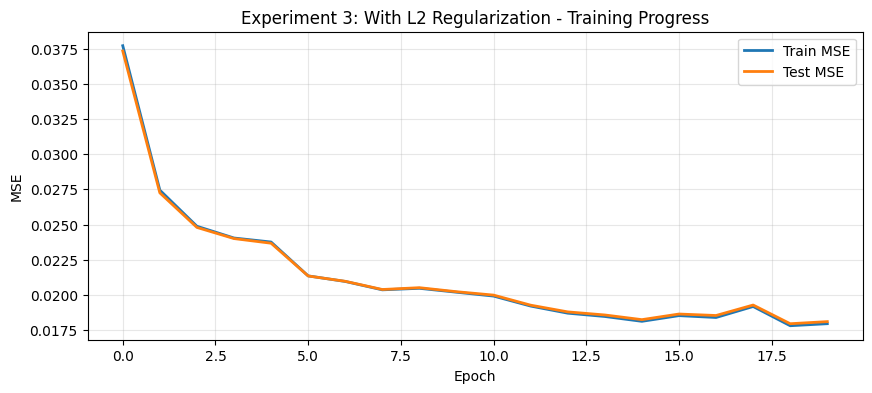

In [ ]:
# Visualize Experiment 3 training progress
plt.figure(figsize=(10, 4))
plt.plot(model_3.train_losses, label='Train MSE', linewidth=2)
plt.plot(model_3.test_losses, label='Test MSE', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Experiment 3: With L2 Regularization - Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
print("="*60)
print("EXPERIMENT 4: Higher Learning Rate")
print("="*60)

# Higher learning rate
model_4 = Autoencoder(input_dim=784, encoding_dims=[128, 32, 128], learning_rate=0.05, regularization=0.0)

model_4.train(X_train_noisy, X_train_clean, X_test_noisy, X_test_clean, epochs=20, batch_size=32)

results.append({
    'Experiment': 4,
    'Description': 'Higher LR (0.05)',
    'Architecture': '[784, 128, 32, 128, 784]',
    'Learning_Rate': 0.05,
    'Regularization': 0.0,
    'Train_MSE': model_4.train_losses[-1],
    'Test_MSE': model_4.test_losses[-1]
})
models[4] = model_4

print(f"\nFinal Test MSE: {model_4.test_losses[-1]:.6f}")

EXPERIMENT 4: Higher Learning Rate
Epoch 5/20 - Train MSE: 0.026783, Test MSE: 0.026633
Epoch 10/20 - Train MSE: 0.020791, Test MSE: 0.020789
Epoch 15/20 - Train MSE: 0.019664, Test MSE: 0.019764
Epoch 20/20 - Train MSE: 0.019035, Test MSE: 0.019125

Final Test MSE: 0.019125


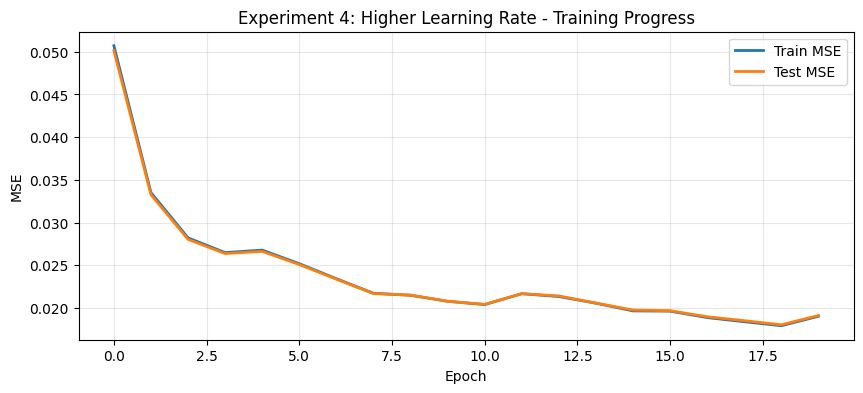

In [ ]:
# Visualize Experiment 4 training progress
plt.figure(figsize=(10, 4))
plt.plot(model_4.train_losses, label='Train MSE', linewidth=2)
plt.plot(model_4.test_losses, label='Test MSE', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Experiment 4: Higher Learning Rate - Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Print all results
print("="*60)
print("ALL EXPERIMENT RESULTS")
print("="*60)

results_df = pd.DataFrame(results)
print(results_df[['Experiment', 'Description', 'Test_MSE']].to_string(index=False))

# Find best model (lowest Test MSE)
best_result = min(results, key=lambda x: x['Test_MSE'])
best_model = models[best_result['Experiment']]

print("\n" + "="*60)
print("BEST MODEL")
print("="*60)
print(f"Experiment: {best_result['Experiment']}")
print(f"Description: {best_result['Description']}")
print(f"Architecture: {best_result['Architecture']}")
print(f"Learning Rate: {best_result['Learning_Rate']}")
print(f"Regularization: {best_result['Regularization']}")
print(f"Test MSE: {best_result['Test_MSE']:.6f}")
print(f"Test RMSE: {np.sqrt(best_result['Test_MSE']):.6f}")

ALL EXPERIMENT RESULTS
 Experiment         Description  Test_MSE
          1            Baseline  0.018965
          2 Smaller Latent (16)  0.020426
          3   L2 Regularization  0.018094
          4    Higher LR (0.05)  0.019125

BEST MODEL
Experiment: 3
Description: L2 Regularization
Architecture: [784, 128, 32, 128, 784]
Learning Rate: 0.01
Regularization: 0.001
Test MSE: 0.018094
Test RMSE: 0.134515


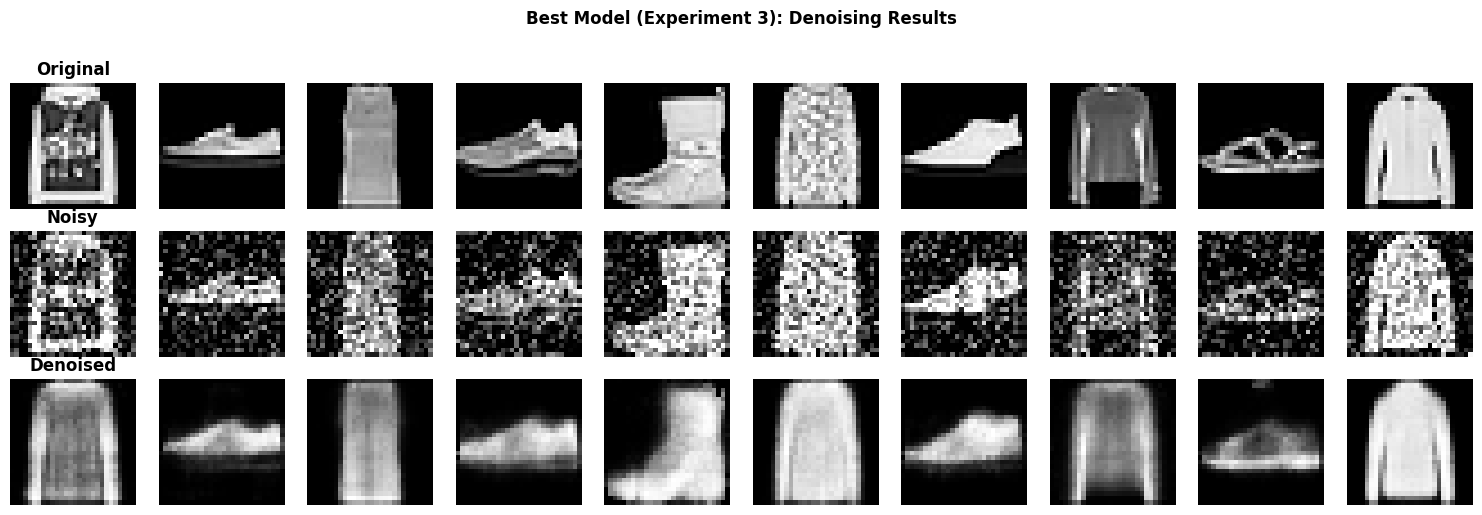

Denoising successful!


In [ ]:
# Reconstruct using best model
reconstructed = best_model.predict(X_test_noisy[:10])

fig, axes = plt.subplots(3, 10, figsize=(15, 5))

for i in range(10):
    axes[0, i].imshow(X_test_clean[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title('Original', fontweight='bold')

    axes[1, i].imshow(X_test_noisy[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title('Noisy', fontweight='bold')

    axes[2, i].imshow(reconstructed[i].reshape(28, 28), cmap='gray')
    axes[2, i].axis('off')
    if i == 0:
        axes[2, i].set_title('Denoised', fontweight='bold')

plt.suptitle(f"Best Model (Experiment {best_result['Experiment']}): Denoising Results", fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# Save experiment log to CSV
results_df.to_csv('autoencoder_experiment_log.csv', index=False)
print("Experiment log saved to 'autoencoder_experiment_log.csv'")